#### Fashion MNIST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn import preprocessing, pipeline, decomposition, manifold
from tensorflow import keras
import tensorflow as tf
from custom_objects import decorators

**Data Collection**

In [3]:
# Load data
fashion_mnist = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# Split into training and testing sets
fashion_train, fashion_test = fashion_mnist
X_train, y_train = fashion_train
X_test, y_test = fashion_test

In [5]:
X_train.shape

(60000, 28, 28)

**Preprocessing**

In [6]:
# Find the first image of each kind
def list_distinct(X, y, n_classes):
    distinct_items = []
    for i in range(n_classes):
        distinct_items.append(X[y==i][0])
    return distinct_items

In [7]:
# From https://www.tensorflow.org/tutorials/keras/classification
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

In [8]:
# Plot all distinct images
def plot_grid(items, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    for item, class_, axis in zip(items, CLASS_NAMES, axes.flat):
        axis.imshow(item, cmap='binary')
        axis.set_title(class_)
        axis.axis('off')

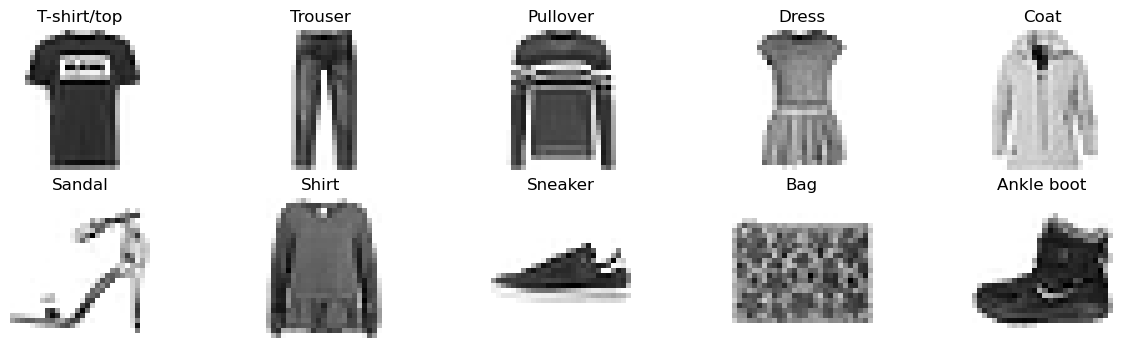

In [9]:
plot_grid(list_distinct(X_train, y_train, 10))

There isn't much of preprocessing required as images in keras datasets are pretty much preprocessed already. Even though, since processing images is computationally expensive, I will try to compress them slightly using PCA. Also, we need to flatten 28x28 images so that they are 784x1.

I am using a custom decorator that I had created to convert functions into sklearn FunctionTransformers, saved in ``my_decorators`` module.

In [10]:
# Define the function to flatten images
@decorators.sklearn_transformer
def Flatten(X, y=None):
    n = X.shape[0]
    b = X.shape[1:]
    return X.reshape(n, np.prod(b))

**PCA**

In [11]:
# PCA preserving 97 % variance
pca = decomposition.PCA(n_components=0.97)
X_train_flat = Flatten.fit_transform(X_train)
X_train_compressed = pca.fit_transform(X_train_flat)

In [12]:
X_train_compressed.shape

(60000, 277)

Not surprisingly, 97% of the information content is explained by only 277 out of 784 features. Let us visualize the dataset by compressing it down to 2D using t-SNE. For the sake of clarity, I will only plot the first 4000 examples.

**t-SNE**

In [13]:
X_4000, y_4000 = X_train_flat[:4000, :], y_train[:4000]

tsne = manifold.TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
X_viz = tsne.fit_transform(X_4000)

In [14]:
# Function to plot 2D compressed data
def plot_2D(X=X_viz, y=y_4000, class_names=CLASS_NAMES):
    plt.figure(figsize=(8, 7))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.jet(label / max(y)), markersize=10, label=class_names[label]) for label in set(y)]
    plt.scatter(X[:, 0], X[:, 1], cmap='jet', c=y, alpha=0.4)
    plt.legend(handles=legend_elements, title='Class Name')

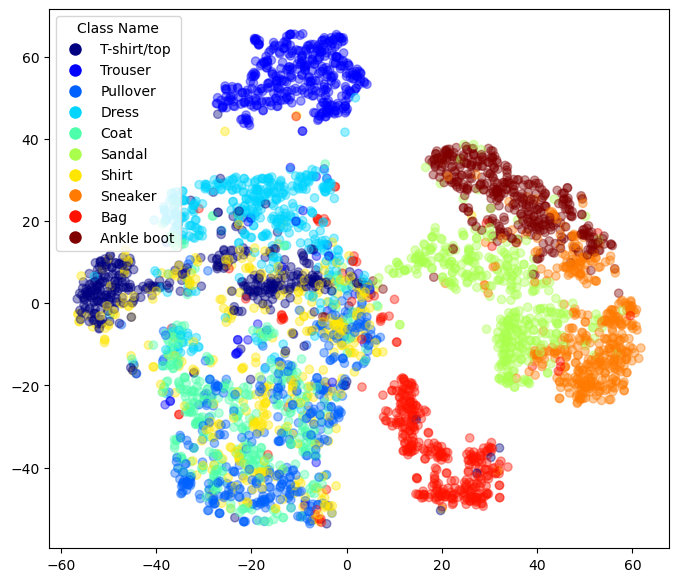

In [15]:
plot_2D()

Nice, most of the classes have separated nicely, even in 2 dimensions. There is some overlap among Sandals, Ankle Boots and Sneakers, which makes sense because they look the same. I have to decided to go with the **277 features** using PCA instead of full dataset, which will save a lot of computing time without losing much accuracy. Let us prepare the final data preparation pipeline, which includes:
1. Flattening the examples
2. PCA with 97% variance ratio
3. Min-max scaling

In [16]:
# Final Pipeline
prep_pipe = pipeline.Pipeline([('flatten', Flatten),
                               ('pca', decomposition.PCA(n_components=0.97)),
                               ('scaler', preprocessing.MinMaxScaler())])

X_train_prep = prep_pipe.fit_transform(X_train)

In [17]:
X_train_prep.shape

(60000, 277)

In [ ]:
# Saving models and data
np.savetxt('/data/X_train_prep.csv', X_train_prep, delimiter=',', fmt='%f')
joblib.dump(prep_pipe, 'saved_models/prep_pipe.pkl')

#If there is an error in this cell, skip this.

We have prepared the final training set using the data preparation pipeline (which can be applied to the test set as is), now let's head straight to training.

**Training**

I have built a model with:
* Input Layer accepting 277 features
* Hidden Layer 1 with _300 neurons_ and _ELU_ activation initialized with _He Normal_
* Hidden Layer 2 with _100 neurons_ and _ELU_ activation initialized with _He Normal_
* Output Layer with _10 neurons_ (as we have 10 classes) and _Softmax_ activation function

The model is optimized by _Nadam_ minimizing _Sparse Categorical Cross-Entropy_.

In [ ]:
model = keras.models.Sequential(layers=[
    keras.layers.InputLayer(input_shape=(277,)),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
], name='two_layer_sequential')

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
es_cb = keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True)

model.fit(X_train_prep, y_train, epochs=100, callbacks=[es_cb], validation_split=0.25, use_multiprocessing=True)

# Set the use_multiprocessing argument to False if running on your personal computer.

Epoch 1/100


2024-01-28 18:21:46.879860: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 18:21:47.026039: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fae410300a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 18:21:47.026052: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-01-28 18:21:47.034614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-28 18:21:47.048542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706484107.105155    6772 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 [==============================] - 4s 2ms/step - loss: 0.7888 - accuracy: 0.7314 - val_loss: 0.8377 - val_accuracy: 0.6953
Epoch 2/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5141 - accuracy: 0.8166 - val_loss: 0.5745 - val_accuracy: 0.7894
Epoch 3/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4881 - accuracy: 0.8265 - val_loss: 0.6090 - val_accuracy: 0.7882
Epoch 4/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4663 - accuracy: 0.8323 - val_loss: 0.4610 - val_accuracy: 0.8319
Epoch 5/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4517 - accuracy: 0.8370 - val_loss: 0.4521 - val_accuracy: 0.8365
Epoch 6/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4350 - accuracy: 0.8434 - val_loss: 0.4612 - val_accuracy: 0.8335
Epoch 7/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4218 - accuracy: 0.8462 - val_loss: 0.5032 - val_accuracy: 0.82

86% of validation accuracy seems pretty good for the first run, given that it converged in just 32 epochs. Had I used the full features instead of applying PCA, the same  model would get me higher accuracy; but I traded lower accuracy for higher speed - look at the time per step in this model (8ms/step), which is half of that of the model below (16ms/step) with full features.
Let us try running the model with the full features without sub-sampling, and see the difference.

**No PCA**

In [21]:
prep_pipe_2 = pipeline.Pipeline([('flatten', Flatten),
                                 ('scaler', preprocessing.MinMaxScaler())])

X_train_prep_2 = prep_pipe_2.fit_transform(X_train)
X_train_prep_2.shape

(60000, 784)

In [22]:
model_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(784, )),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
])

model_2.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history_2 = model_2.fit(X_train_prep_2, y_train, epochs=100, callbacks=[es_cb], validation_split=0.25)

Epoch 1/100
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4816 - accuracy: 0.8261 - val_loss: 0.5170 - val_accuracy: 0.8191
Epoch 2/100
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3697 - accuracy: 0.8644 - val_loss: 0.3652 - val_accuracy: 0.8622
Epoch 3/100
1407/1407 [==============================] - 2s 2ms/step - loss: 0.3317 - accuracy: 0.8761 - val_loss: 0.3659 - val_accuracy: 0.8687
Epoch 4/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3074 - accuracy: 0.8852 - val_loss: 0.3517 - val_accuracy: 0.8743
Epoch 5/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2882 - accuracy: 0.8920 - val_loss: 0.3596 - val_accuracy: 0.8733
Epoch 6/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2706 - accuracy: 0.8972 - val_loss: 0.3482 - val_accuracy: 0.8767
Epoch 7/100
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2566 - accuracy: 0.9009 - val_loss: 0.3585 - val_ac

Okay we did reach an **94% training accuracy** in just over 20 epochs, but the accuracy on validation set is 89%, which means we are overfitting slightly. It seems that the model is a little too complex for the task, so I might remove a few neurons or layers. But before that, it might be useful to focus on the learning rates; we might settle with less bouncing around.

In [ ]:
model_2.save('saved_models/model_2.h5')
model.save('saved_models/model.h5')

**CNN**
Let's tackle this dataset using CNNs instead of fully-connected ANNs.

In [25]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [26]:
cnn_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=30)

Epoch 1/30


2024-01-28 18:25:39.529918: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1875/1875 [==============================] - 8s 3ms/step - loss: 0.8570 - accuracy: 0.7006
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4863 - accuracy: 0.8347
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4172 - accuracy: 0.8572
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3884 - accuracy: 0.8690
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3680 - accuracy: 0.8733
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3596 - accuracy: 0.8762
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3514 - accuracy: 0.8799
Epoch 8/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3394 - accuracy: 0.8838
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3368 - accuracy: 0.8849
Epoch 10/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3324 - accurac

Finally, let us try a custom training loop to get a hold of what's happening under the hoods.

In [32]:
n_epochs = 10
batch_size = 32
n_steps = len(X_train) // batch_size

model_custom = keras.models.clone_model(model)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.Accuracy]

In [33]:
def print_status_bar(iteration, total, loss, metrics):
    metrics = ' - '.join(['{}: {:.4f}'.format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)
    
def random_batch(X, y, batch_size=batch_size):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
for epoch in tf.range(1, n_epochs+1):
    print('Epoch {}/{}'.format(epoch, n_epochs))
    for step in tf.range(1, n_steps+1):
        X_batch, y_batch = random_batch(X_train_prep, y_train)
        with tf.GradientTape() as tape:
            y_pred = model_custom(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_pred, y_batch))
            loss = tf.add_n([main_loss] + model_custom.losses)
        grads = tape.gradient(loss, model_custom.trainable_variables)
        optimizer.apply_gradients(zip(grads,model_custom.trainable_variables))
        mean_loss(loss)
        for metric in metrics:
            metric(y_pred, y_batch)
        print_status_bar(step*batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()


Kartik Kumar
For more projects, please visit [My GithHub Page](https://github.com/ryuukkk)